In [ ]:
!pip install -U datasets
!pip install transformers

In [8]:
transformers.logging.set_verbosity_info() #run this for logs

In [9]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

class TopKSamplerWithEntropy:
    def __init__(self, model, tokenizer, k=10, max_length=50, device="cpu"):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.k = k
        self.max_length = max_length
        self.device = device

    def compute_entropy(self, probs):
        return -torch.sum(probs * probs.log(), dim=-1).item()

    def compute_layerwise_entropy(self, hidden_states):
        """
        hidden_states: tuple of [layer_i] each of shape [1, seq_len, hidden_dim]
        Returns: list of entropy values, one per layer (on the last token)
        """
        entropies = []
        for layer in hidden_states:
            last_token_vec = layer[0, -1, :]
            probs = F.softmax(last_token_vec, dim=-1)
            entropy = self.compute_entropy(probs)
            entropies.append(entropy)
        return entropies

    def sample(self, prompt):
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        output_ids = input_ids.clone()

        output_entropies = []
        layerwise_entropies = []

        for _ in range(self.max_length):
            with torch.no_grad():
                outputs = self.model(output_ids, output_hidden_states=True)
                logits = outputs.logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)

                # Output entropy
                entropy = self.compute_entropy(probs)
                output_entropies.append(entropy)

                # Layerwise entropy
                hidden_states = outputs.hidden_states  # tuple of layers
                layer_entropies = self.compute_layerwise_entropy(hidden_states)
                layerwise_entropies.append(layer_entropies)

                # Top-k sampling
                topk_probs, topk_indices = torch.topk(probs, self.k, dim=-1)
                topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
                next_token = torch.multinomial(topk_probs, num_samples=1)
                next_token_id = topk_indices.gather(-1, next_token)

                output_ids = torch.cat([output_ids, next_token_id], dim=-1)

        generated_text = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return generated_text, output_entropies, layerwise_entropies


In [ ]:
from datasets import load_dataset

dataset = load_dataset("gsm8k", "main", split="train[:1]")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

sampler = TopKSamplerWithEntropy(model, tokenizer, k=10, max_length=30)

for i, example in enumerate(dataset):
    prompt = example["question"]
    print(f"\nPrompt {i + 1}: {prompt}")

    generated, output_entropies, layerwise_entropies = sampler.sample(prompt)

    print("Generated:", generated)
    print("Output Entropies:", output_entropies)
    print("Layerwise Entropies per step:")
    for step, layer_ent in enumerate(layerwise_entropies):
        print(f"Step {step+1}: {layer_ent}")


In [12]:
import matplotlib.pyplot as plt

def plot_output_entropy(entropies, title="Output Token Entropy"):
    plt.figure(figsize=(8, 4))
    plt.plot(entropies, marker='o', color='royalblue')
    plt.title(title)
    plt.xlabel("Generated Token Step")
    plt.ylabel("Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import seaborn as sns
import numpy as np

def plot_layerwise_entropy(layerwise_entropies, title="Layerwise Entropy Heatmap"):
    entropy_array = np.array(layerwise_entropies)
    plt.figure(figsize=(12, 6))
    sns.heatmap(entropy_array.T, cmap="viridis", cbar=True, xticklabels=True)
    plt.title(title)
    plt.xlabel("Generated Token Step")
    plt.ylabel("Layer")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


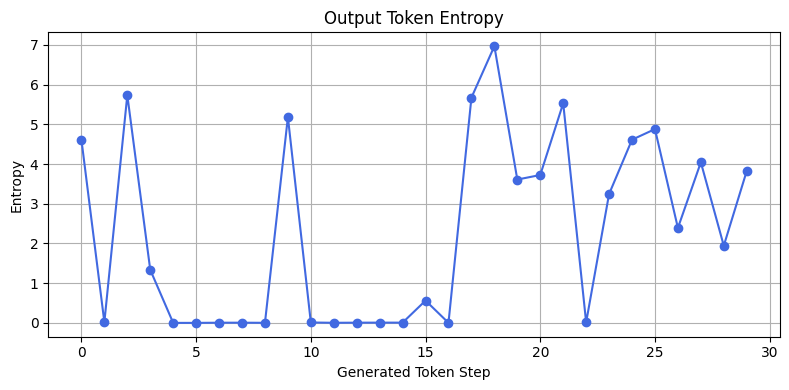

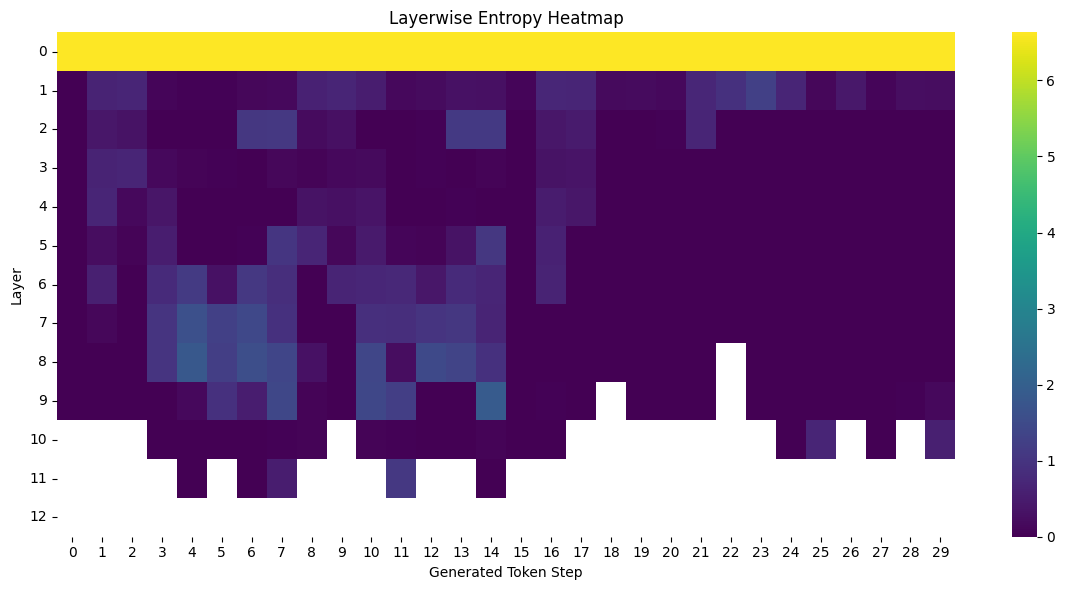

In [13]:
plot_output_entropy(output_entropies)
plot_layerwise_entropy(layerwise_entropies)